In [1]:
import rich
import yaml
import gzip
import hist
import numpy as np
import mplhep as hep
import correctionlib
import correctionlib.convert
from coffea.util import load
import matplotlib.pyplot as plt
from coffea.processor import accumulate

with open("../analysis/postprocess/style.yaml", "r") as f:
    style = yaml.safe_load(f)
with open("../analysis/postprocess/luminosity.yaml", "r") as f:
    lumi = yaml.safe_load(f)
plt.rcParams.update(style["rcParams"])

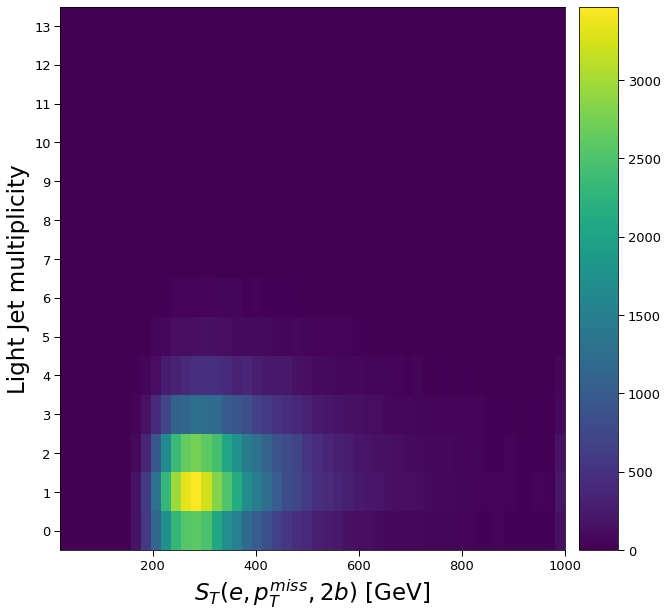

In [2]:
year = "2016postVFP"
workflow = "2b1e"
xlabels = {
    "2b1mu": r"$S_T(\mu, b, p_T^{miss})$ [GeV]",
    "2b1e": r"$S_T(e, 2b, p_T^{miss})$ [GeV]"
}

ph = load(f"../outputs/{workflow}/{year}/{year}_processed_histograms.coffea")

tt = ph["tt"]["st"][{"variation": "nominal"}]
data = ph["Data"]["st"][{"variation": "nominal"}]
nontt = accumulate(
    [
        ph["DYJetsToLL"]["st"][{"variation": "nominal"}],
        ph["SingleTop"]["st"][{"variation": "nominal"}],
        ph["WJetsToLNu"]["st"][{"variation": "nominal"}],
        ph["Diboson"]["st"][{"variation": "nominal"}],
    ]
)
fig, ax = plt.subplots(figsize=(10,10))
data.plot2d(ax=ax);

[Text(0.5, 0, '$S_T(e, 2b, p_T^{miss})$ [GeV]'),
 Text(0, 0.5, 'lightjets multiplicity')]

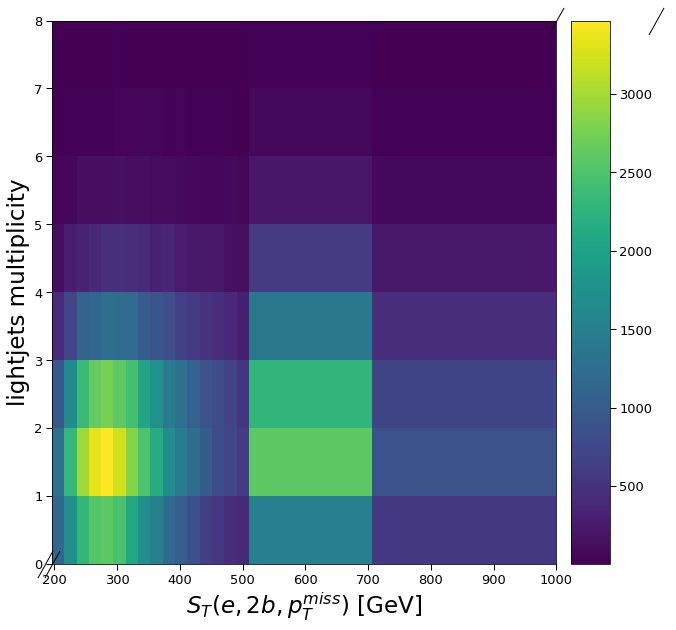

In [3]:
def rebin_hist(h, axis_name, edges):
    if type(edges) == int:
        return h[{axis_name: hist.rebin(edges)}]

    ax = h.axes[axis_name]
    ax_idx = [a.name for a in h.axes].index(axis_name)
    if not all([np.isclose(x, ax.edges).any() for x in edges]):
        raise ValueError(
            f"Cannot rebin histogram due to incompatible edges for axis '{ax.name}'\n"
            f"Edges of histogram are {ax.edges}, requested rebinning to {edges}"
        )

    # If you rebin to a subset of initial range, keep the overflow and underflow
    overflow = ax.traits.overflow or (
        edges[-1] < ax.edges[-1] and not np.isclose(edges[-1], ax.edges[-1])
    )
    underflow = ax.traits.underflow or (
        edges[0] > ax.edges[0] and not np.isclose(edges[0], ax.edges[0])
    )
    flow = overflow or underflow
    new_ax = hist.axis.Variable(
        edges, name=ax.name, overflow=overflow, underflow=underflow
    )
    axes = list(h.axes)
    axes[ax_idx] = new_ax

    hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())

    # Offset from bin edge to avoid numeric issues
    offset = 0.5 * np.min(ax.edges[1:] - ax.edges[:-1])
    edges_eval = edges + offset
    edge_idx = ax.index(edges_eval)
    # Avoid going outside the range, reduceat will add the last index anyway
    if edge_idx[-1] == ax.size + ax.traits.overflow:
        edge_idx = edge_idx[:-1]

    if underflow:
        # Only if the original axis had an underflow should you offset
        if ax.traits.underflow:
            edge_idx += 1
        edge_idx = np.insert(edge_idx, 0, 0)

    # Take is used because reduceat sums i:len(array) for the last entry, in the case
    # where the final bin isn't the same between the initial and rebinned histogram, you
    # want to drop this value. Add tolerance of 1/2 min bin width to avoid numeric issues
    hnew.values(flow=flow)[...] = np.add.reduceat(
        h.values(flow=flow), edge_idx, axis=ax_idx
    ).take(indices=range(new_ax.size + underflow + overflow), axis=ax_idx)
    if hnew._storage_type() == hist.storage.Weight():
        hnew.variances(flow=flow)[...] = np.add.reduceat(
            h.variances(flow=flow), edge_idx, axis=ax_idx
        ).take(indices=range(new_ax.size + underflow + overflow), axis=ax_idx)
    return hnew


st_new_edges = [
    196.4,
    216.0,
    235.6,
    255.2,
    274.8,
    294.4,
    314.0,
    333.6,
    353.2,
    372.8,
    392.4,
    412.0,
    431.6,
    451.2,
    470.8,
    490.4,
    510.0,
    706.0,
    1000,
]

njet_new_edges = [0,1,2, 3, 4, 5, 6, 7, 8]

tt = rebin_hist(tt, "st", st_new_edges)
data = rebin_hist(data, "st", st_new_edges)
nontt = rebin_hist(nontt, "st", st_new_edges)

tt = rebin_hist(tt, "lightjets_multiplicity", njet_new_edges)
data = rebin_hist(data, "lightjets_multiplicity", njet_new_edges)
nontt = rebin_hist(nontt, "lightjets_multiplicity", njet_new_edges)

fig, ax = plt.subplots(figsize=(10,10))
data.plot2d(ax=ax)
ax.set(xlabel=xlabels[workflow], ylabel="lightjets multiplicity")

In [4]:
# compute SF 
num = (data + (-1 * nontt)).values()
den = tt.values()
sf = np.where((num > 0) & (den > 0), num / (den + 1e-32), 1)
sfhist = hist.Hist(*data.axes[:], data=sf)

# build correctionlib object from histogram
sfhist.name = "boost_weight"
sfhist.label = "out"
boost_weight = correctionlib.convert.from_histogram(sfhist)
boost_weight.description = "tt boost weights"
# set overflow bins behavior (default is to raise an error when out of bounds)
boost_weight.data.flow = "clamp"
rich.print(boost_weight)

📈 boost_weight (v0)
tt boost weights
Node counts: MultiBinning: 1
╭────────────── ▶ input ──────────────╮ ╭─────────── ▶ input ────────────╮
│ st (real)                           │ │ lightjets_multiplicity (real)  │
│ st                                  │ │ lightjets_multiplicity         │
│ Range: [196.4, 1000.0), overflow ok │ │ Range: [0.0, 8.0), overflow ok │
╰─────────────────────────────────────╯ ╰────────────────────────────────╯
╭─── ◀ output ───╮
│ out (real)     │
│ No description │
╰────────────────╯

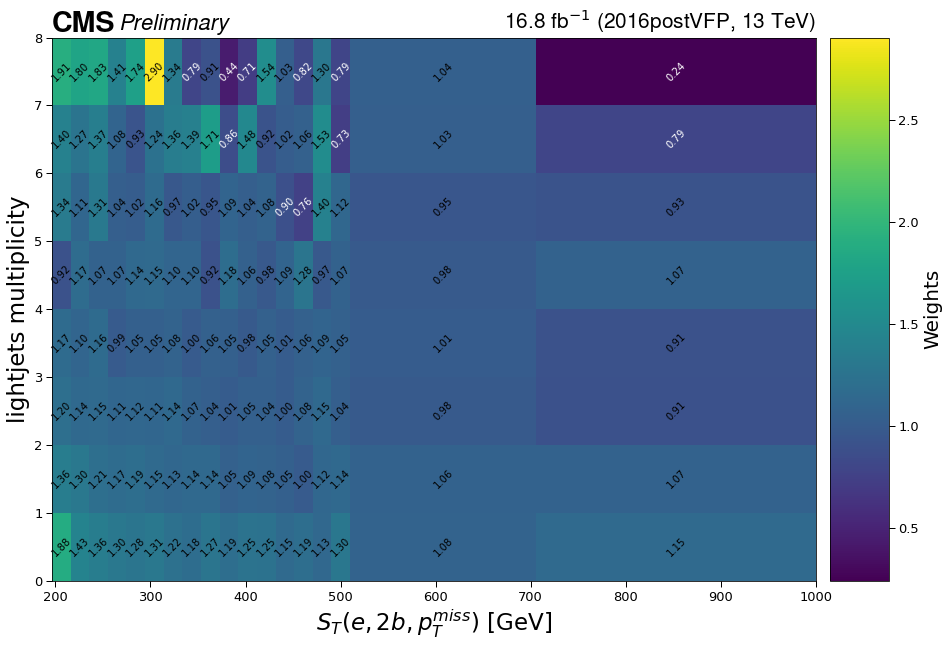

In [5]:
st_bins = data.project("st").axes.edges[0]
n_jets_bins = data.project("lightjets_multiplicity").axes.edges[0]
st_centers = data.project("st").axes.centers[0]
jet_centers = data.project("lightjets_multiplicity").axes.centers[0]
st, jet_n = np.meshgrid(st_bins, n_jets_bins)
SF = boost_weight.to_evaluator().evaluate(st, jet_n)

data_matrix = np.zeros((len(st_bins)-1, len(n_jets_bins)-1))
for y in range(SF.shape[0]-1):
    for x in range(SF.shape[1]-1):
        data_matrix[x, y] = SF[y, x]

fig, ax = plt.subplots(figsize=(15, 10))
boost_hist = hist.Hist(*data.axes[:], data=data_matrix)
colormesh = boost_hist.plot2d(ax=ax)
colormesh[1].set_label("Weights", fontsize=20)
ax.set(xlabel=xlabels[workflow], ylabel="lightjets multiplicity")

for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        val = data_matrix[i, j]
        x = st_centers[i]
        y = jet_centers[j]
        if val < 0.9 or np.isnan(val):
            col = 'w'
        else:
            col = 'k'
        ax.text(x, y, f"{val:.2f}", rotation=45, ha="center", va="center", fontsize=10, color=col)

hep.cms.lumitext(f"{lumi[year] * 1e-3:.1f} fb$^{{-1}}$ ({year}, 13 TeV)", ax=ax, fontsize=22)
hep.cms.text("Preliminary", fontsize=22)
fig.savefig(f"boost_weight_{workflow}_{year}.png")
fig.savefig(f"boost_weight_{workflow}_{year}.pdf")

In [6]:
# Fit to polynomial of order 2,2
centers = np.meshgrid(*[ax.centers for ax in sfhist.axes], indexing="ij")
boost_weight, fit = correctionlib.convert.ndpolyfit(
    points=[c.flatten() for c in centers],
    values=sfhist.values().flatten(),
    weights=1 / sfhist.variances().flatten(),
    varnames=[ax.name for ax in sfhist.axes],
    degree=(2, 2),
)
boost_weight.name = "boost_weight"
rich.print(boost_weight)

📈 boost_weight (v1)
Fit to polynomial of order 2,2
Fit status: The unconstrained solution is optimal.
chi2 = 2.3505355246022823, P(dof=135) = 1.000
Node counts: Formula: 1
╭──────────── ▶ input ────────────╮ ╭──────────── ▶ input ────────────╮
│ st (real)                       │ │ lightjets_multiplicity (real)   │
│ No description                  │ │ No description                  │
│ Range: [-inf, inf), overflow ok │ │ Range: [-inf, inf), overflow ok │
╰─────────────────────────────────╯ ╰─────────────────────────────────╯
╭─── ◀ output ───╮
│ output (real)  │
│ No description │
╰────────────────╯

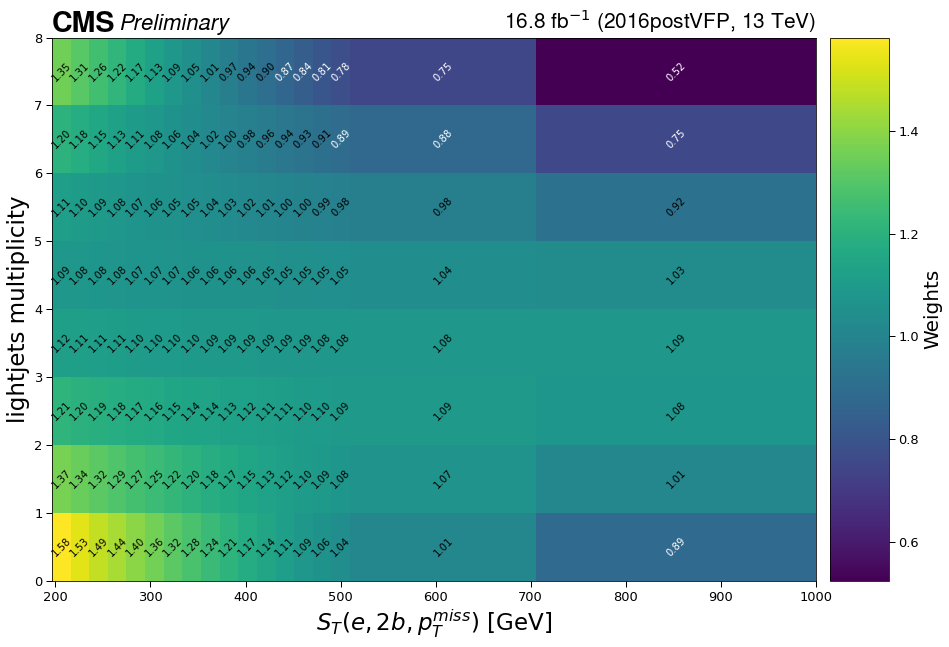

In [7]:
st_bins = data.project("st").axes.edges[0]
n_jets_bins = data.project("lightjets_multiplicity").axes.edges[0]
st_centers = data.project("st").axes.centers[0]
jet_centers = data.project("lightjets_multiplicity").axes.centers[0]
st, jet_n = np.meshgrid(st_bins, n_jets_bins)
SF = boost_weight.to_evaluator().evaluate(st, jet_n)

data_matrix = np.zeros((len(st_bins)-1, len(n_jets_bins)-1))
for y in range(SF.shape[0]-1):
    for x in range(SF.shape[1]-1):
        data_matrix[x, y] = SF[y, x]

fig, ax = plt.subplots(figsize=(15, 10))
boost_hist = hist.Hist(*data.axes[:], data=data_matrix)
colormesh = boost_hist.plot2d(ax=ax)
colormesh[1].set_label("Weights", fontsize=20)
ax.set(xlabel=xlabels[workflow], ylabel="lightjets multiplicity")

for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        val = data_matrix[i, j]
        x = st_centers[i]
        y = jet_centers[j]
        if val < 0.9 or np.isnan(val):
            col = 'w'
        else:
            col = 'k'
        ax.text(x, y, f"{val:.2f}", rotation=45, ha="center", va="center", fontsize=10, color=col)

hep.cms.lumitext(f"{lumi[year] * 1e-3:.1f} fb$^{{-1}}$ ({year}, 13 TeV)", ax=ax, fontsize=22)
hep.cms.text("Preliminary", fontsize=22)
fig.savefig(f"boost_weight_poly_{workflow}_{year}.png")
fig.savefig(f"boost_weight_poly_{workflow}_{year}.pdf")

In [8]:
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="tt boost weight",
    corrections=[
        boost_weight
    ],
)
with gzip.open(f"../analysis/data/{year}_{workflow}_boost_weight.json.gz", "wt") as fout:
    fout.write(cset.json(exclude_unset=True))